In [4]:
import pandas as pd
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textstat
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [5]:
path = 'state-of-the-union-corpus-1989-2017'
dirs = os.listdir(path)

In [6]:
df = pd.DataFrame(columns=['year', 'president', 'party', 'text'])

for i in range(len(dirs)):
    components = dirs[i].split('_')
    name = components[0]
    year = components[1].split('.')[0]
    df.loc[i,'year'] = year
    df.loc[i,'president'] = name   
    
    filename = os.path.join(path, dirs[i])
    text_file = open(filename, "r")
    
    lines = text_file.read()
    lines = lines.replace('\n', ' ')
    df.loc[i, 'text'] = lines.lower()
    
df.year = df.year.astype(int) 
df.president = df.president.astype(str)
df.text = df.text.astype(str)
print('Shape: ', df.shape)

Shape:  (228, 4)


There are a few presidents that have the same last name (Roosevelt, Bush, Johnson and Adams), so let's clean that up now.

In [7]:
# need to distinuish between Theodore Roosevelt and Franklin D. Roosevelt
indices = df.query("president =='Roosevelt' & year <= 1909").index
df.loc[indices,'president'] = 'Theodore Roosevelt'

indices = df.query("president == 'Roosevelt'").index
df.loc[indices,'president'] = 'Franklin D. Roosevelt'

indices = df.query("president =='Bush' & year <= 1992").index
df.loc[indices,'president'] = 'George H. W. Bush'

indices = df.query("president == 'Bush'").index
df.loc[indices,'president'] = 'George W. Bush'

indices = df.query("president =='Johnson' & year <= 1869").index
df.loc[indices,'president'] = 'Andrew Johnson'

indices = df.query("president == 'Johnson'").index
df.loc[indices,'president'] = 'Lyndon B. Johnson'

indices = df.query("president =='Adams' & year <= 1801").index
df.loc[indices,'president'] = 'John Adams'

indices = df.query("president == 'Adams'").index
df.loc[indices,'president'] = 'John Quincy Adams'


indices = df.query("president =='Harrison' & year <= 1841").index
df.loc[indices,'president'] = 'William Henry Harrison'

indices = df.query("president == 'Harrison'").index
df.loc[indices,'president'] = 'Benjamin Harrison'

Now let's attach the political party to the president (note some presidents changed parties throughout their political career, I am simply listing the party they belonged to while serving as President).

In [8]:
def pres_to_party(name):
    republican = ['Lincoln', 'Grant', 'Hayes', 'Garfield', 'Arthur', 
                  'Benjamin Harrison', 'McKinley', 'Theodore Roosevelt', 
                  'Taft', 'Harding', 'Coolidge', 'Hoover', 'Eisenhower', 
                  'Nixon', 'Ford', 'Reagan', 'George H. W. Bush', 
                  'George W. Bush', 'Trump']
    if name in republican:
        return 'Republican'
    
    democratic = ['Jackson', 'Buren', 'Polk', 'Pierce', 
                  'Buchanan', 'Cleveland', 'Wilson', 'Franklin D. Roosevelt', 
                  'Truman', 'Kennedy', 'Lyndon B. Johnson', 'Carter', 'Clinton', 'Obama']
    if name in democratic:
        return 'Democratic'
    
    whig = ['William Henry Harrison', 'Taylor', 'Fillmore']
    if name in whig:
        return 'Whig'
    
    national_union = ['Andrew Johnson']
    if name in national_union:
        return 'National Union'
    
    
    unaffiliated = ['Washington', 'Tyler']
    if name in unaffiliated:
        return 'Unaffiliated'
    
    federalist = ['John Adams']
    if name in federalist:
        return 'Federalist'
    
    democratic_republican = ['Jefferson', 'Madison', 'Monroe', 'John Quincy Adams']
    if name in democratic_republican:
        return 'Democratic-Republican'

In [9]:
df.party = df.president.apply(pres_to_party)

df.set_index('year', inplace=True)
df.sort_index(inplace=True)
df.head()

,president,party,text
year,,,
1790,Washington,Unaffiliated,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [10]:
# need to drop George Washington's 1790 address as the file is empty
df = df.iloc[1:,:]
df.head()

,president,party,text
year,,,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1795,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [11]:
df.groupby('party').size()

party
Democratic               88
Democratic-Republican    28
Federalist                4
National Union            4
Republican               89
Unaffiliated             10
Whig                      4
dtype: int64

In [12]:
import re
from gensim import models, corpora
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [13]:
NUM_TOPICS = 10
STOPWORDS = stopwords.words('english')

In [14]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return lemmatize_sent(' '.join(cleaned_text))

In [15]:
df['tokens'] = df.text.apply(clean_text)

In [16]:
df.head()

,president,party,text,tokens
year,,,,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."
1795,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...,"[fellow-citizens, senate, house, representativ..."


Let's make a **word cloud**, using the original text (not tokenized).

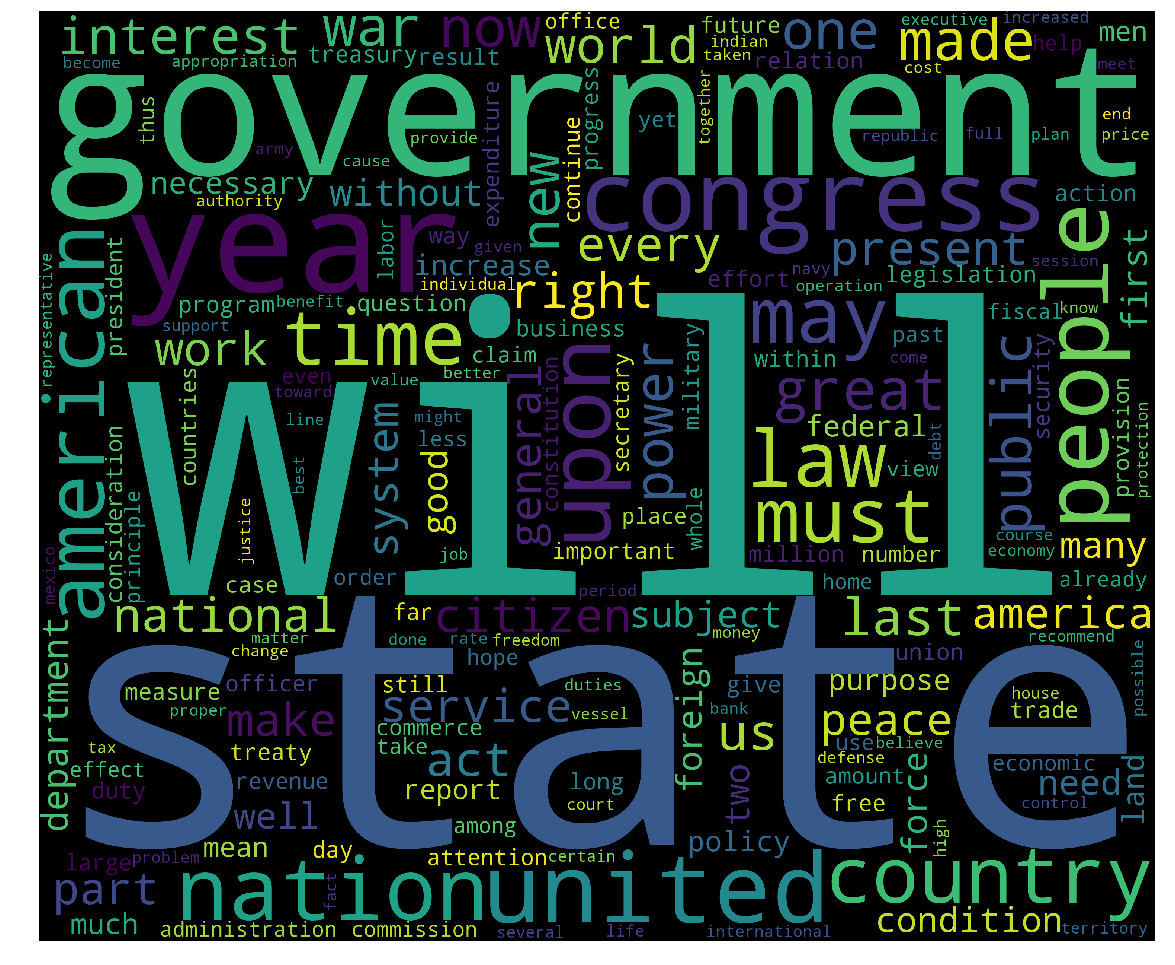

In [42]:
#WordCloud
from wordcloud import WordCloud, STOPWORDS

cleaned_text = ' '.join(list(df.text))

wordcloud = WordCloud(stopwords=STOPWORDS,max_words=200,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(cleaned_text)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Now let's make one using our **tokens** (lemmatized and stemmed).

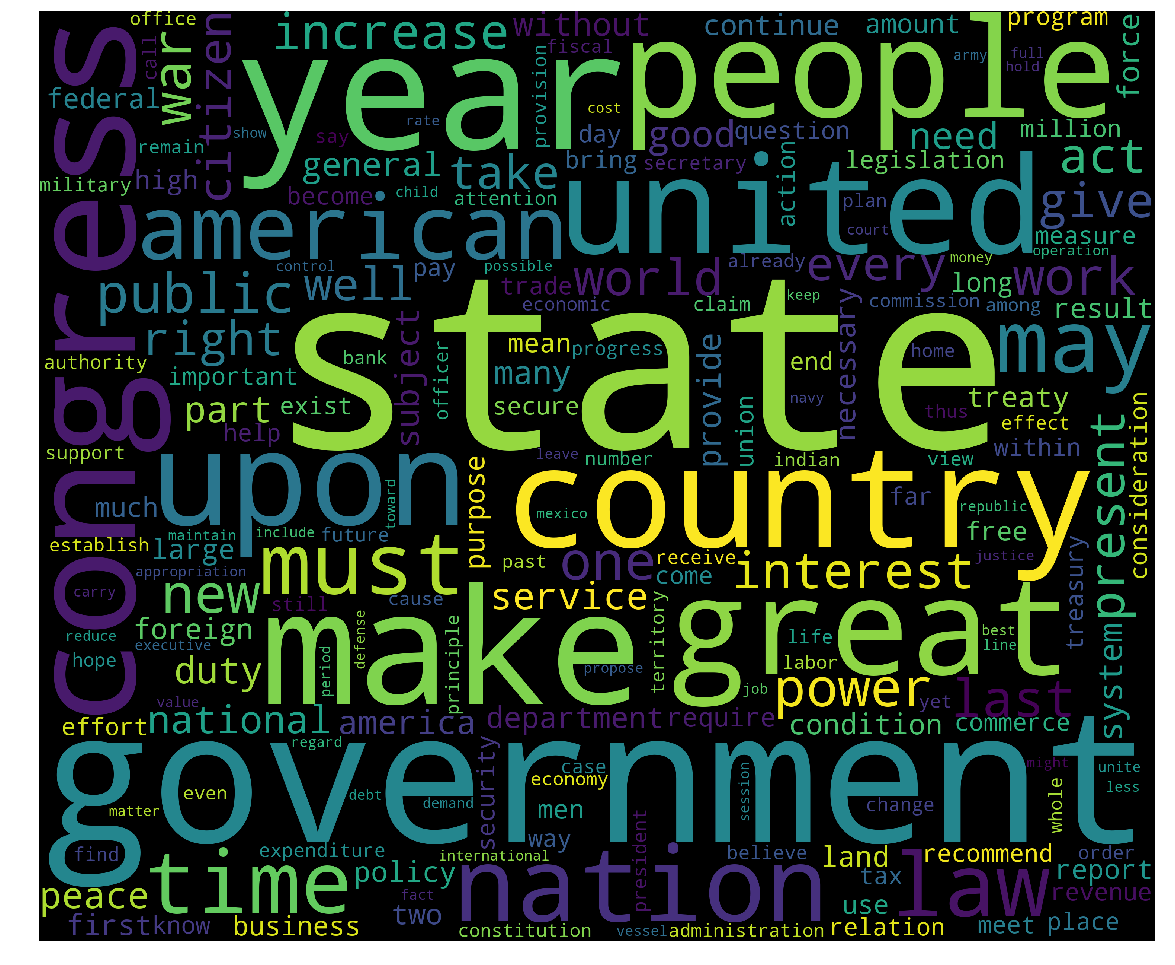

In [43]:
token_string = ''
for tokens in df.tokens:
    token_string += ' '.join(tokens) + ' '

wordcloud_tokens = WordCloud(stopwords=STOPWORDS,max_words=200,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(token_string)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud_tokens)
plt.axis('off')
plt.show()

# Topic Modeling

In [63]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df.tokens)

'''
We can "control" the level in which we extract topics from:
  * We can filter out tokens that show up in x% of all SOTU's, in effect
    uncovering more hidden topics (only present in (1-x)% of the SOTUs).
  * A similar strategy can be used to filter out very rare tokens by setting
    no_below

Initially we will not do this, but it follows that this strategy might be helpful

in classification models. In this case we might also want to increase
  the number of latent topics to discover: less frequenct topics could be 
  quite powerful in prediction
'''
dictionary.filter_extremes(no_above=.3)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df.tokens]

In [64]:
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, 
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

In [65]:
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, 
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

In [66]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
    
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
    
print("=" * 20)

LDA Model:
Topic #0: 0.002*"soviet" + 0.002*"tonight" + 0.002*"silver" + 0.002*"gold" + 0.002*"percent" + 0.002*"commitment" + 0.002*"housing" + 0.001*"bureau" + 0.001*"postal" + 0.001*"democracy"
Topic #1: 0.004*"gold" + 0.002*"tonight" + 0.002*"silver" + 0.002*"mexican" + 0.002*"percent" + 0.001*"spanish" + 0.001*"arbitration" + 0.001*"soviet" + 0.001*"award" + 0.001*"tribunal"
Topic #2: 0.004*"tonight" + 0.001*"democracy" + 0.001*"inflation" + 0.001*"commitment" + 0.001*"spending" + 0.001*"nuclear" + 0.001*"percent" + 0.001*"veteran" + 0.001*"panama" + 0.001*"silver"
Topic #3: 0.005*"tonight" + 0.003*"percent" + 0.003*"nuclear" + 0.002*"soviet" + 0.002*"college" + 0.002*"inflation" + 0.002*"parent" + 0.002*"student" + 0.002*"democracy" + 0.002*"technology"
Topic #4: 0.003*"tonight" + 0.002*"percent" + 0.002*"gold" + 0.002*"texas" + 0.002*"democracy" + 0.002*"veteran" + 0.002*"spanish" + 0.001*"silver" + 0.001*"circulation" + 0.001*"housing"
Topic #5: 0.002*"tonight" + 0.002*"soviet"

Now that we have extracted the top 10 most likely topics, we can apply them to each address separately.

In [67]:
lsi_scores = [] # np.array((len(corpus), NUM_TOPICS))
lda_scores = [] #np.array((len(corpus), NUM_TOPICS))

for i in range(len(corpus)):
    x = lsi_model[corpus[i]]
    #lsi_scores.append([score[1] for score in x])
    lsi_scores.append({score[0]:score[1] for score in x})
    y = lda_model[corpus[i]]
    #lda_scores.append([score[1] for score in y])
    lda_scores.append({score[0]:score[1] for score in y})
    
lsi_df = pd.DataFrame(lsi_scores)
lsi_df.index = df.index

lda_df = pd.DataFrame(lda_scores)
lda_df.index = df.index
lda_df.fillna(0.0, inplace=True)
lsi_df.fillna(0.0, inplace=True)

lda_df.head()

,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
1791,0.000000,0.723723,0.0,0.0,0.0,0.0,0.000000,0.000000,0.273102,0.000000
1792,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.995832,0.000000
1793,0.000000,0.193333,0.0,0.0,0.0,0.0,0.000000,0.000000,0.335924,0.467311
1794,0.000000,0.010539,0.0,0.0,0.0,0.0,0.028394,0.369971,0.548453,0.041431
1795,0.072047,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.396831,0.528408


Attach political party to lsi_scores to see if there is any major differences between the political parties.

In [68]:
lda_df['party'] = df.party
lda_df.groupby('party').mean()

,0,1,2,3,4,5,6,7,8,9
party,,,,,,,,,,
Democratic,0.003256,0.107108,0.043522,0.447487,0.046147,0.015730,0.020858,0.065761,0.211646,0.034568
Democratic-Republican,0.000000,0.074028,0.015715,0.000000,0.004113,0.005984,0.009324,0.016261,0.731548,0.138901
Federalist,0.069307,0.260020,0.016894,0.000000,0.000000,0.000000,0.000000,0.000000,0.631785,0.017176
National Union,0.069202,0.164831,0.000000,0.000000,0.000000,0.003119,0.013111,0.328100,0.370434,0.048727
Republican,0.022850,0.176300,0.013463,0.448728,0.084595,0.019140,0.019213,0.025705,0.162787,0.023090
Unaffiliated,0.007205,0.096325,0.000000,0.000000,0.016255,0.003564,0.002839,0.046081,0.703564,0.120387
Whig,0.000000,0.121270,0.000000,0.000000,0.014693,0.041501,0.002577,0.101858,0.686884,0.025923


In [69]:
lsi_df['party'] = df.party
lsi_df.groupby('party').mean()

,0,1,2,3,4,5,6,7,8,9
party,,,,,,,,,,
Democratic,16.388994,2.640948,-4.301889,-0.306050,3.996049,1.993019,1.342723,-1.353600,0.972876,0.016493
Democratic-Republican,5.434990,-2.594786,-1.834685,-1.566901,0.030980,0.262270,3.942489,-1.298951,-0.221449,0.104498
Federalist,2.436423,-1.336157,-0.813504,-0.379839,0.133340,-0.020407,1.727587,-0.231034,-0.473045,0.067450
National Union,16.913307,-8.945914,-4.953210,3.742043,0.632805,0.728320,5.485599,-4.200895,2.703841,2.607828
Republican,17.742173,0.294776,3.165243,-0.029111,2.743428,0.325165,0.658930,1.138829,-0.875833,0.589798
Unaffiliated,7.737076,-4.275900,-4.486116,-1.491272,0.160722,0.187474,1.224211,-2.198536,1.399019,1.024902
Whig,16.997059,-8.864203,-7.764337,-7.330475,-0.145019,-0.201097,6.942835,-2.599603,1.910158,-0.063226


So topic scores should really help our classification model!

<Figure size 1440x504 with 0 Axes>

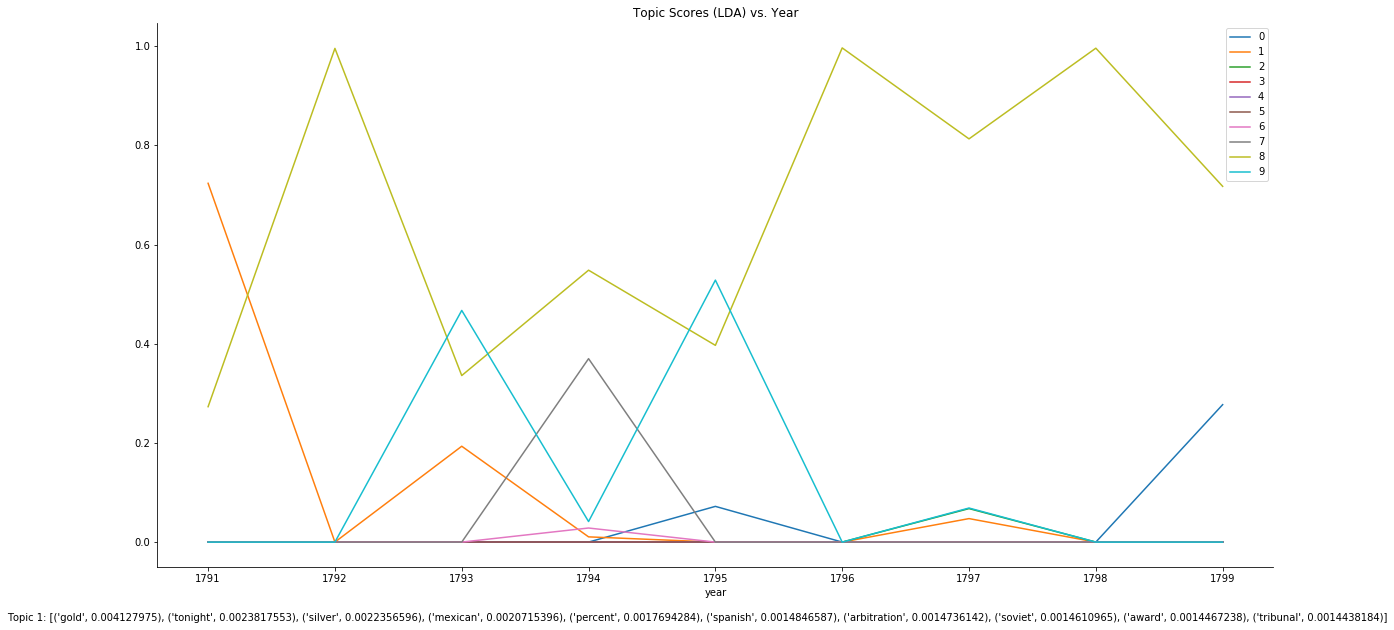

<Figure size 432x288 with 0 Axes>

In [93]:
plt.figure(figsize=(20,7))
lda_df.query('year < 1800').plot.line()
plt.title('Topic Scores (LDA) vs. Year')
sns.despine()
fig = plt.gcf()
fig.set_size_inches(20, 10)
txt = "Topic 1: " + str(lda_model.show_topic(1,10))
fig.text(.5, .05, txt, ha='center')
plt.savefig('topics_before_1800_lda.png')
plt.show()
plt.clf()

<Figure size 1440x504 with 0 Axes>

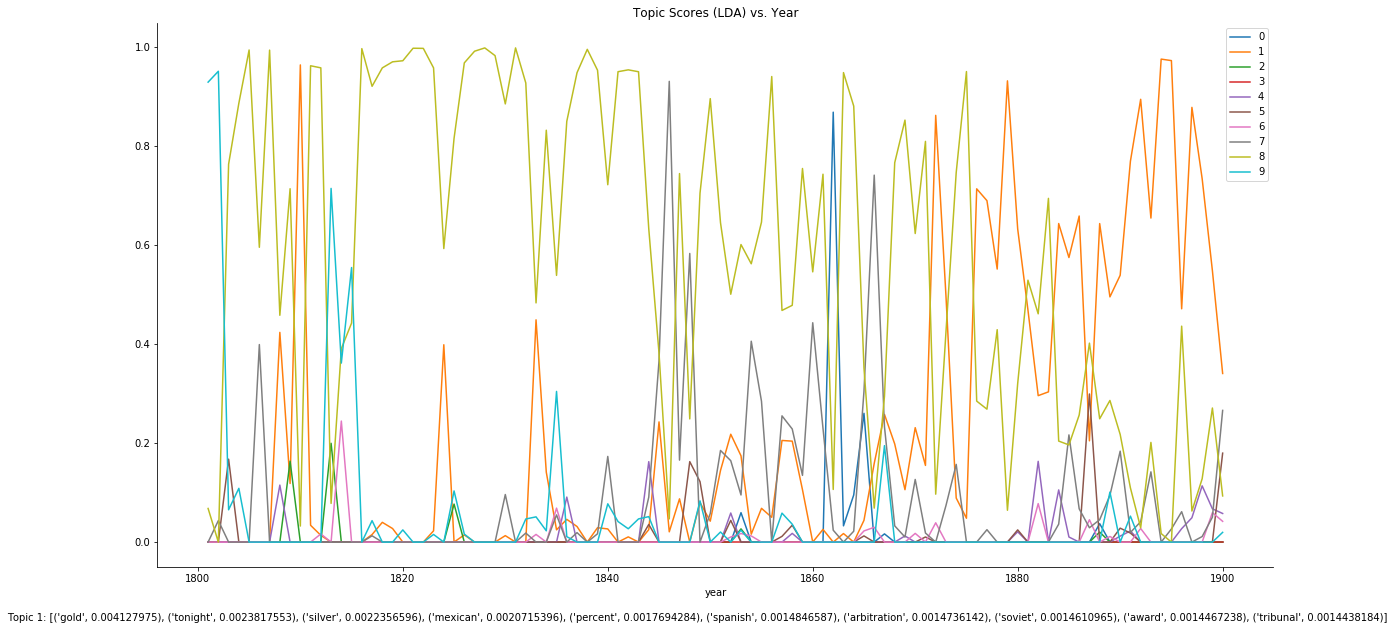

<Figure size 432x288 with 0 Axes>

In [94]:
plt.figure(figsize=(20,7))
lda_df.query('year > 1800 & year <= 1900').plot.line()
plt.title('Topic Scores (LDA) vs. Year')
sns.despine()
fig = plt.gcf()
fig.set_size_inches(20, 10)
txt = "Topic 1: " + str(lda_model.show_topic(1,10))
fig.text(.5, .05, txt, ha='center')
plt.savefig('topics_after_1800_before_1900_lda.png')
plt.show()
plt.clf()

**Takeaway:**  
Before 1800, there were only a few "latent" topics present in all SOTU addresses, which upon closer examination encapsulates a lot of the themes present during that time, specifically precious metals.  
After 1800 it becomes much more difficult to distinguish the strengths of the top 10 topics inferred by LDA, but there does appear to be a significant change around 1960. Let us look at this further.

<Figure size 1440x504 with 0 Axes>

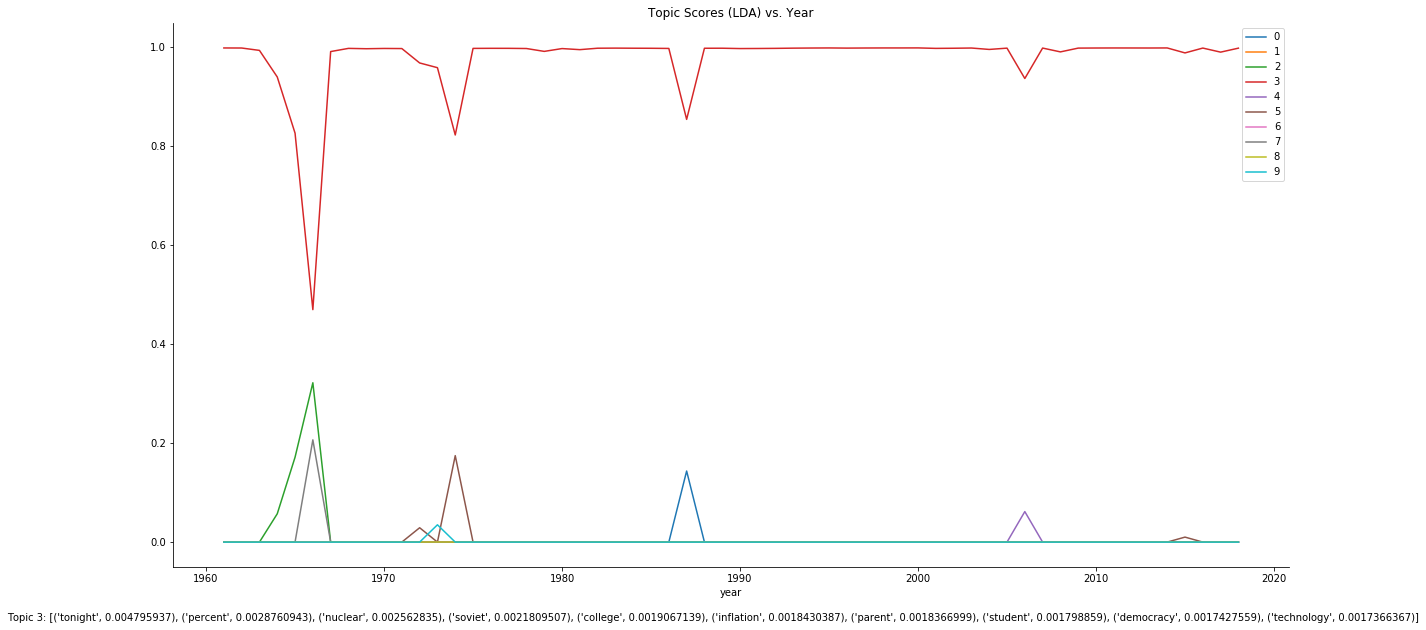

<Figure size 432x288 with 0 Axes>

In [95]:
plt.figure(figsize=(20,7))
lda_df.query('year > 1960').plot.line()
plt.title('Topic Scores (LDA) vs. Year')
sns.despine()
fig = plt.gcf()
fig.set_size_inches(20, 10)
txt = "Topic 3: " + str(lda_model.show_topic(3,10))
fig.text(.5, .05, txt, ha='center')
plt.savefig('topics_after_1960_lda.png')
plt.show()
plt.clf()

Basically after 2000, none of the topics discovered via LDA seem to be present except topic 3, and a little of topics 2 and 7 (middle on the 1960's). Once again, this seems to be indicative of the times: soviet, nuclear, democracy, students and technology. As one should expect, SOTU addresses essentially reflect the times.

<Figure size 1440x720 with 0 Axes>

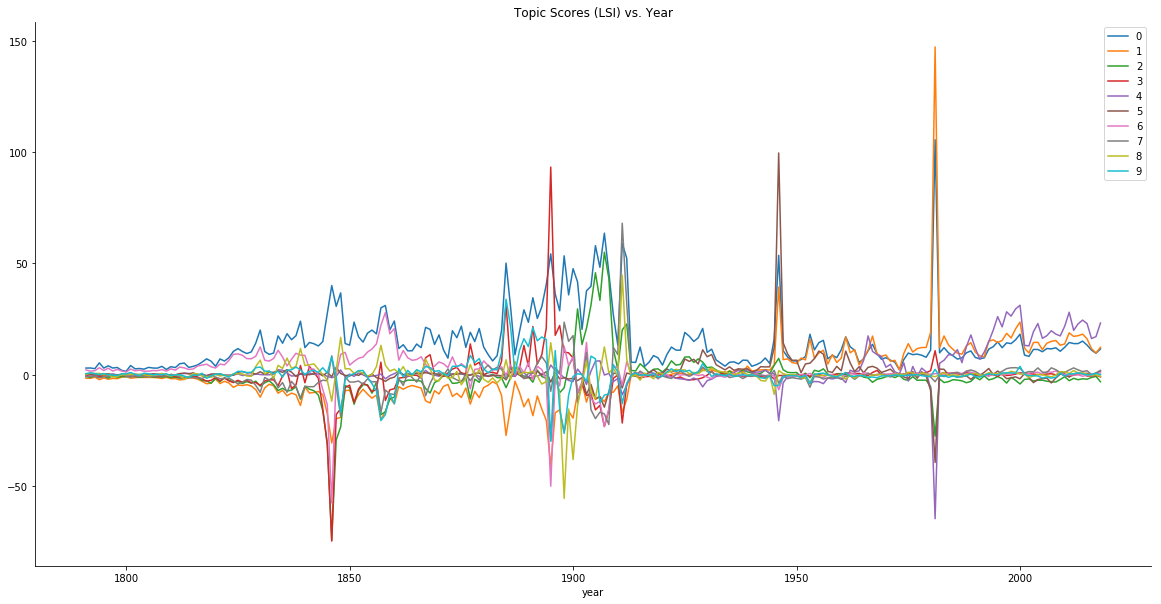

<Figure size 432x288 with 0 Axes>

In [96]:
plt.figure(figsize=(20,10))
lsi_df.drop('party', axis=1).plot.line()
plt.title('Topic Scores (LSI) vs. Year')
sns.despine()
plt.gcf().set_size_inches(20, 10)
plt.savefig('topics_lsi.png')
plt.show()
plt.clf()

Topic #0: 0.306*"state" + 0.276*"government" + 0.204*"year" + 0.189*"make" + 0.165*"congress" + 0.150*"country" + 0.145*"upon" + 0.143*"united" + 0.132*"great" + 0.132*"would"  

We can filter out terms that dominate the speeches in an effort to uncover "more" latent topics.

Regardless of what I set no_above to (for excluding terms that appear very often), I still see peaks (both positive and negative) around the same times, what I imagine to be around 1960 and 1980. I observed more 'peaks' prior to 1830, however the magnitude of the difference in peak high and low are much smaller. These topics appear to be decreasing in strength since the millennium. 

Now let's download and clean Trump's 2019 SOTU address and see what the strength of these inferred topics are.

# Classification  

For this project I will be building a model to accurately classify political party. I manually curated this information to match up with the order the files were read in (in dirs variable).

In [97]:
tokenized_docs = []
for tokens in df.tokens:
    ts = ' '.join(tokens)
    tokenized_docs.append(ts)

In [98]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(stop_words='english')
bow = cv.fit_transform(tokenized_docs).toarray()

In [99]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(bow, 
                                                    df.party, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [100]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
print('Training score: ',sgd.score(X_train, y_train))
y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred))

Training score:  0.9668508287292817
                       precision    recall  f1-score   support

           Democratic       1.00      0.42      0.59        19
Democratic-Republican       1.00      0.67      0.80         6
           Federalist       0.00      0.00      0.00         1
       National Union       0.17      1.00      0.29         1
           Republican       0.80      0.84      0.82        19
         Unaffiliated       0.00      0.00      0.00         0
                 Whig       0.00      0.00      0.00         0

            micro avg       0.63      0.63      0.63        46
            macro avg       0.42      0.42      0.36        46
         weighted avg       0.88      0.63      0.69        46



That is not great accuracy, let's improve this!

In [118]:
cv = CountVectorizer(stop_words='english', 
                     max_df=.9, 
                     min_df=6)
bow = cv.fit_transform(tokenized_docs).toarray()

X_train, X_test, y_train, y_test = train_test_split(bow, 
                                                    df.party, 
                                                    test_size=0.2, 
                                                    random_state=42)

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
print('Training score: ',sgd.score(X_train, y_train))
y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred))

Training score:  1.0
                       precision    recall  f1-score   support

           Democratic       0.89      0.84      0.86        19
Democratic-Republican       1.00      1.00      1.00         6
           Federalist       1.00      1.00      1.00         1
       National Union       1.00      1.00      1.00         1
           Republican       0.85      0.89      0.87        19

            micro avg       0.89      0.89      0.89        46
            macro avg       0.95      0.95      0.95        46
         weighted avg       0.89      0.89      0.89        46



Wow a few changed to the default hyper-parameters used when computing our bag of words improved our classification accuracy from 63% (micro average) to 89%!  

Now let's add the topic scores and see how that impacts our model.

In [119]:
X_lsi = np.concatenate((bow, lsi_df.drop('party', axis=1).values), axis=1)

In [120]:
X_lsi_train, X_lsi_test, y_lsi_train, y_lsi_test = train_test_split(X_lsi, 
                                                    df.party, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [121]:
sgd_lsi = SGDClassifier()
sgd_lsi.fit(X_lsi_train, y_lsi_train)
print('Training score: ',sgd_lsi.score(X_lsi_train, y_train))
y_pred_lsi = sgd_lsi.predict(X_lsi_test)
print(classification_report(y_lsi_test, y_pred_lsi))

Training score:  1.0
                       precision    recall  f1-score   support

           Democratic       0.86      0.95      0.90        19
Democratic-Republican       1.00      0.83      0.91         6
           Federalist       1.00      1.00      1.00         1
       National Union       1.00      1.00      1.00         1
           Republican       0.94      0.89      0.92        19

            micro avg       0.91      0.91      0.91        46
            macro avg       0.96      0.94      0.95        46
         weighted avg       0.92      0.91      0.91        46



**So using our topic scores we improved the overall accuracy to 91%, however it is important to notice how the precision/recall scores changed for each party. Because the non-Republican and non-Democratic classes are so small, we should expect poor performance here. Can we improve on this imbalance issue?**